In [50]:
%load_ext autoreload
%autoreload 2


from glob import glob
from itertools import chain, combinations
import math
import re

# import ensembl_rest
import numpy as np
import pandas as pd
from sourmash import load_signatures

import requests, sys
from pprint import pprint

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
 
from sklearn.metrics import auc, roc_curve

import tqdm

from sklearn import metrics

import seaborn as sns

from khtools.ensembl import get_sequence, maybe_get_cds


from khtools.compare_peptide import compare_all_seqs
from khtools.homology import HomologyTable



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
!tree /home/olga/data_sm/kmer-hashing/orthologues/

/home/olga/data_sm/kmer-hashing/orthologues/
├── human-vs-mouse
│   ├── non_coding_orthology_nsubset1000_seed0.csv
│   └── protein_coding_peptide_orthology_nsubset10000_seed0.csv
├── human-vs-mouse_lemur
│   ├── n_homology_types.csv
│   ├── protein_coding_peptide_orthology_nsubset1000_seed0.csv
│   └── protein_coding_peptide_orthology_nsubset200_seed0.csv
└── mouse-vs-mouse_lemur
    └── n_homology_types.csv

3 directories, 6 files


In [9]:
from IPython.display import display

In [41]:
folder = '/home/olga/data_sm/kmer-hashing/orthologues/'
dfs = []
for filename in glob(f"{folder}/*/n_homology_types.csv"):
    df = pd.read_csv(filename)
#     display(df)
    dfs.append(df)
n_homology_types = pd.concat(dfs, ignore_index=True)
n_homology_types['species_comparison'] = n_homology_types['species1'] + ' :: ' + n_homology_types['species2']
n_homology_types

,homology_type,n_transcripts,seqtype,species1,species2,species_comparison
0,ortholog_many2many,3553,protein_coding,human,mouse lemur,human :: mouse lemur
1,ortholog_one2many,20708,protein_coding,human,mouse lemur,human :: mouse lemur
2,ortholog_one2one,127810,protein_coding,human,mouse lemur,human :: mouse lemur
3,ortholog_many2many,94,non_coding,human,mouse lemur,human :: mouse lemur
4,ortholog_one2many,280,non_coding,human,mouse lemur,human :: mouse lemur
5,ortholog_one2one,628,non_coding,human,mouse lemur,human :: mouse lemur
6,ortholog_many2many,12356,protein_coding,human,mouse,human :: mouse
7,ortholog_one2many,15346,protein_coding,human,mouse,human :: mouse
8,ortholog_one2one,131456,protein_coding,human,mouse,human :: mouse
9,ortholog_many2many,1162,non_coding,human,mouse,human :: mouse


In [42]:
n_homology_types['percent_per_species_comparison'] = \
    n_homology_types.groupby("species_comparison", as_index=False).apply(lambda x: 100*x['n_transcripts']/x['n_transcripts'].sum()).values
n_homology_types

,homology_type,n_transcripts,seqtype,species1,species2,species_comparison,percent_per_species_comparison
0,ortholog_many2many,3553,protein_coding,human,mouse lemur,human :: mouse lemur,7.619588
1,ortholog_one2many,20708,protein_coding,human,mouse lemur,human :: mouse lemur,9.463434
2,ortholog_one2one,127810,protein_coding,human,mouse lemur,human :: mouse lemur,81.065114
3,ortholog_many2many,94,non_coding,human,mouse lemur,human :: mouse lemur,0.716572
4,ortholog_one2many,280,non_coding,human,mouse lemur,human :: mouse lemur,0.538971
5,ortholog_one2one,628,non_coding,human,mouse lemur,human :: mouse lemur,0.596321
6,ortholog_many2many,12356,protein_coding,human,mouse,human :: mouse,2.321115
7,ortholog_one2many,15346,protein_coding,human,mouse,human :: mouse,13.528186
8,ortholog_one2one,131456,protein_coding,human,mouse,human :: mouse,83.496110
9,ortholog_many2many,1162,non_coding,human,mouse,human :: mouse,0.061409


In [43]:
n_homology_types['percent_per_species_comparison_and_seqtype'] = \
    n_homology_types.groupby(["species_comparison", 'seqtype'], as_index=False).apply(lambda x: 100*x['n_transcripts']/x['n_transcripts'].sum()).values
n_homology_types

,homology_type,n_transcripts,seqtype,species1,species2,species_comparison,percent_per_species_comparison,percent_per_species_comparison_and_seqtype
0,ortholog_many2many,3553,protein_coding,human,mouse lemur,human :: mouse lemur,7.619588,38.694639
1,ortholog_one2many,20708,protein_coding,human,mouse lemur,human :: mouse lemur,9.463434,29.104229
2,ortholog_one2one,127810,protein_coding,human,mouse lemur,human :: mouse lemur,81.065114,32.201132
3,ortholog_many2many,94,non_coding,human,mouse lemur,human :: mouse lemur,0.716572,7.763355
4,ortholog_one2many,280,non_coding,human,mouse lemur,human :: mouse lemur,0.538971,9.641991
5,ortholog_one2one,628,non_coding,human,mouse lemur,human :: mouse lemur,0.596321,82.594654
6,ortholog_many2many,12356,protein_coding,human,mouse,human :: mouse,2.321115,9.381238
7,ortholog_one2many,15346,protein_coding,human,mouse,human :: mouse,13.528186,27.944112
8,ortholog_one2one,131456,protein_coding,human,mouse,human :: mouse,83.496110,62.674651
9,ortholog_many2many,1162,non_coding,human,mouse,human :: mouse,0.061409,2.336409


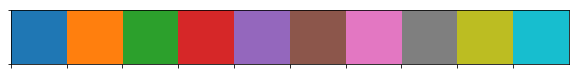

In [49]:
sns.palplot(sns.color_palette())

In [51]:
orthology_categories = ['No homology', 'ortholog_many2many', 'ortholog_one2many', 'ortholog_one2one']

palette = dict(zip(orthology_categories, ['grey'] + sns.color_palette()))
palette

{'No homology': 'grey',
 'ortholog_many2many': (0.12156862745098039,
  0.4666666666666667,
  0.7058823529411765),
 'ortholog_one2many': (1.0, 0.4980392156862745, 0.054901960784313725),
 'ortholog_one2one': (0.17254901960784313,
  0.6274509803921569,
  0.17254901960784313)}

/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


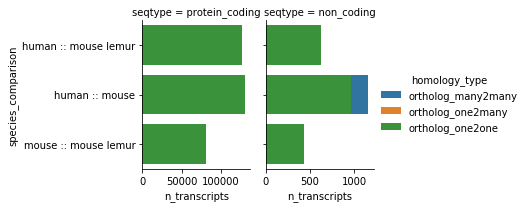

In [52]:
g = sns.FacetGrid(data=n_homology_types, hue='homology_type', col='seqtype', sharex=False, palette=palette)
g.map(sns.barplot, 'n_transcripts', 'species_comparison')
g.add_legend()

In [63]:
n_homology_types_stacked = n_homology_types.set_index("species_comparison")
n_homology_types_stacked

,homology_type,n_transcripts,seqtype,species1,species2,percent_per_species_comparison,percent_per_species_comparison_and_seqtype
species_comparison,,,,,,,
human :: mouse lemur,ortholog_many2many,3553,protein_coding,human,mouse lemur,7.619588,38.694639
human :: mouse lemur,ortholog_one2many,20708,protein_coding,human,mouse lemur,9.463434,29.104229
human :: mouse lemur,ortholog_one2one,127810,protein_coding,human,mouse lemur,81.065114,32.201132
human :: mouse lemur,ortholog_many2many,94,non_coding,human,mouse lemur,0.716572,7.763355
human :: mouse lemur,ortholog_one2many,280,non_coding,human,mouse lemur,0.538971,9.641991
human :: mouse lemur,ortholog_one2one,628,non_coding,human,mouse lemur,0.596321,82.594654
human :: mouse,ortholog_many2many,12356,protein_coding,human,mouse,2.321115,9.381238
human :: mouse,ortholog_one2many,15346,protein_coding,human,mouse,13.528186,27.944112
human :: mouse,ortholog_one2one,131456,protein_coding,human,mouse,83.496110,62.674651


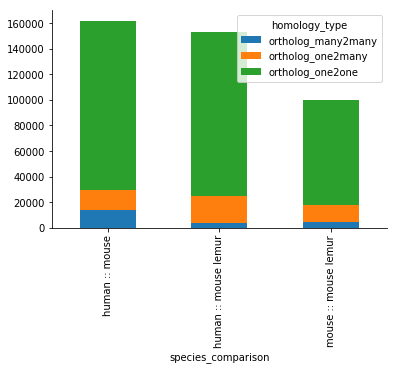

In [75]:
pivoted = n_homology_types.pivot_table(index=['homology_type', 'seqtype'], columns='species_comparison', values='n_transcripts')

pivoted_per_homology = pivoted.groupby(level=0).sum()

pivoted_per_homology.T.plot(kind='bar', stacked='True')
sns.despine()

In [ ]:
pivoted = n_homology_types.pivot_table(index=['homology_type', 'seqtype'], columns='species_comparison', values='n_transcripts')

pivoted_per_seqtype = pivoted.groupby(level=-1).sum()

pivoted_per_homology.T.plot(kind='bar', stacked='True')
sns.despine()

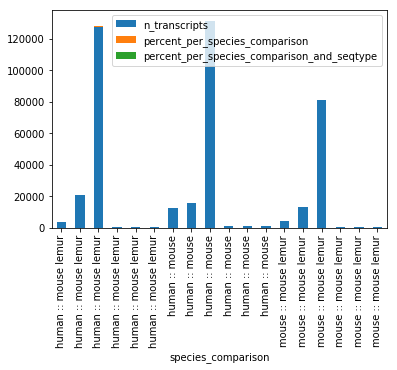

In [62]:
n_homology_types.set_index("species_comparison").plot(kind='bar', stacked='True')

In [ ]:
g = sns.FacetGrid(data=n_homology_types, hue='homology_type', col='seqtype', sharex=False, palette=palette)
g.map(sns.barplot, 'n_transcripts', 'species_comparison')
g.add_legend()

In [ ]:
g = sns.catplot('n_transcripts', 'species_comparison', data=n_homology_types, palette=palette,
                hue='homology_type', col='seqtype', sharex=False, kind='bar')

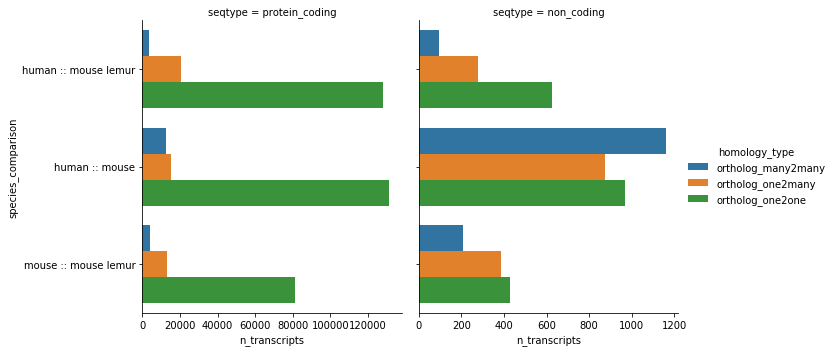

In [54]:
g = sns.catplot('n_transcripts', 'species_comparison', data=n_homology_types, palette=palette,
                hue='homology_type', col='seqtype', sharex=False, kind='bar')

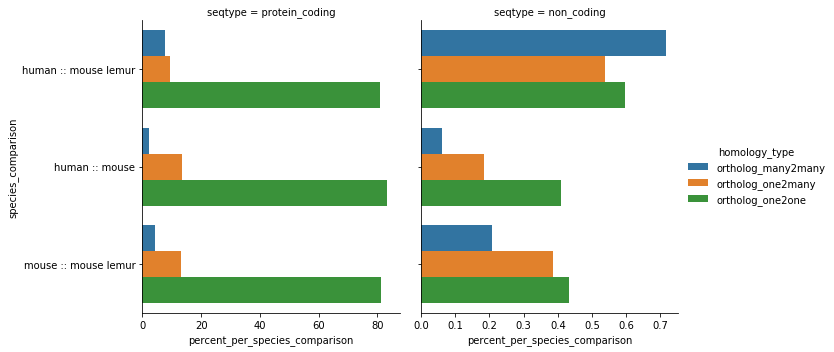

In [55]:
g = sns.catplot('percent_per_species_comparison', 'species_comparison', data=n_homology_types, palette=palette,
                hue='homology_type', col='seqtype', sharex=False, kind='bar')

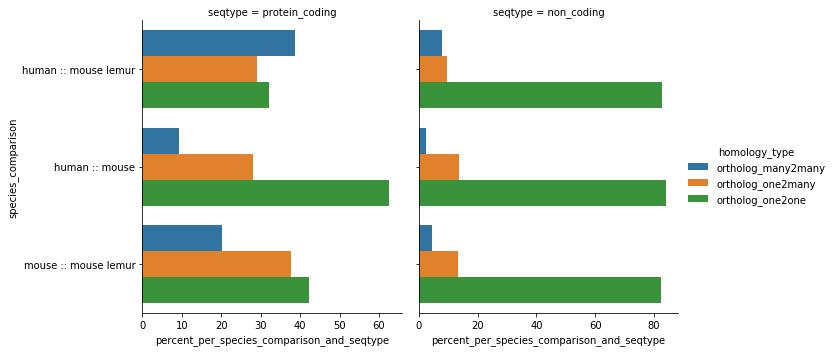

In [56]:
g = sns.catplot('percent_per_species_comparison_and_seqtype', 'species_comparison', data=n_homology_types, palette=palette,
                hue='homology_type', col='seqtype', sharex=False, kind='bar')